# epoching

Here we form epochs out of the continuous, cleaned data.

The workflow is as follows:

1. Load the behavioral data for a participant. Each row in the dataframe reflects one drawn sample (across all tasks)
    1. we drop the description task for now
1. Load the events for that participant, and refine the events so that each row in the events array reflects one drawn sample
1. Define an `EVENT_PARAMS` dictionary that contains all parameters of interest for each event. for example, a "sample" event may be described along multiple other dimensions such as what the following outcome was, the number of the sample in its sequence, etc. (this is defined in `utils.py`)
1. Using the events array and the dataframe for a subject, re-define the "code" of each event to encode information along all dimensions of the `EVENT_PARAMS` dictionary. For example, the code `1` (reflecting a sample drawn) can become a `12443` (reflecting a sample drawn on the left side, with an outcome of "9", etc.) (this is defined in `utils.py`)
1. Use the refined events array to form epochs for further analysis

---

The meaning of the markers in the events file can be taken from the
`provide_trigger_dict` function.

Note that the markers are shifted to distinguish by tasks:

- AF          += 100
- AV          += 200
- YF          += 300
- YV          += 400
- description += 500


In [1]:
%matplotlib qt

In [2]:
import itertools
import multiprocessing
import os.path as op

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from utils import (
    BIDS_ROOT,
    EVENT_ID,
    EVENT_PARAMS,
    TASK_BASED_INCREMENTS,
    TASK_NAME_MAP,
    bin_outcomes,
    find_bad_epochs,
    provide_trigger_dict,
    spm_orth,
    task_not_present_for_subject,
    add_binned_outcomes_to_df,
)

In [3]:
# IO: Where to find the data
# Where to find event data, and behavioral data
fname_events_template = op.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_concat_eeg-eve.fif.gz"
)

fname_cleanraw_template = op.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_clean_eeg-raw.fif.gz"
)

fname_behavioral = op.join(BIDS_ROOT, "code", "behavioral_data.csv")

# Where to save the epochs
fname_epo_template = op.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_epochs-epo.fif.gz"
)


# Pack all names in a dict
name_templates = dict()
name_templates["events"] = fname_events_template
name_templates["cleanraw"] = fname_cleanraw_template
name_templates["epochs"] = fname_epo_template

In [4]:
# Define other variables, read overall behavioral data
tasks = ["ActiveFixed", "ActiveVariable", "YokedFixed", "YokedVariable", "description"]

df = pd.read_csv(fname_behavioral)


def get_df_for(df, subject, task):
    return df[(df["subject"] == subject) & (df["task"] == task)]

In [5]:
def drop_error_events(events):
    """Drop error rows from events array."""
    trigger_dict = provide_trigger_dict()

    # Collect indices of events to delete
    del_idxs = list()
    for task, increment in TASK_BASED_INCREMENTS.items():
        ERROR_CODE = ord(trigger_dict["trig_error"]) + increment
        NEW_TRL_CODE = ord(trigger_dict["trig_new_trl"]) + increment

        err_idxs = np.nonzero(events[:, -1] == ERROR_CODE)[0]
        new_trl_idxs = np.nonzero(events[:, -1] == NEW_TRL_CODE)[0]

        for err_i in err_idxs:
            # event after error is always new_trl
            new_trl_i = err_i + 1
            assert events[new_trl_i, -1] == NEW_TRL_CODE

            # find idx of new_trl event before error
            prev = list(new_trl_idxs).index(new_trl_i) - 1
            idx = new_trl_idxs[prev]

            # we need to delete all rows from that new trial
            # to the error (inclusively)
            del_idxs.extend(np.arange(idx, err_i + 1))

    # Delete the triggers associated with errors
    new_events = np.delete(events, del_idxs, axis=0)
    print("deleted {} events.".format(len(del_idxs)))

    return new_events

In [6]:
def get_codes_across_tasks(codes):
    """Get list of corresponding codes.

    Parameters
    ----------
    codes : list of int
        The event codes we are interested to find in each task.

    Returns
    -------
    codes_across_tasks : list of int
        The original codes mapped to the value they have in the
        different tasks. For example, the event code 1 is 101
        in the AF task, 201 in the AV task, 301 in the YF task, etc.

    See also
    --------
    utils.TASK_BASED_INCREMENTS

    """
    codes_across_tasks = list()
    for code in codes:
        for task, increment in TASK_BASED_INCREMENTS.items():
            codes_across_tasks.append(code + increment)

    return codes_across_tasks

In [7]:
def _classify_switch(df, event_idx):
    """Classify a sampling action into a kind of switch behavior.

    Each row in `df` as indexed by `event_idx` corresponds to a sampling
    action. A sampling action can be either left (0) or right (1) and is
    part of a sequence of sampling actions.

    Parameters
    ----------
    df : pd.DataFrame
        The data for all events.
    event_idx : int
        The event_idx into the data for the current event to be classified.

    Returns
    -------
    switch : str
        One of ['no_switch', 'pre_switch', 'post_switch', 'mixed_switch'].

    Notes
    -----
    Each sampling action (left or right) is first evaluated whether it is
    the same as the previous (=stay), or different(=switch). Next, the
    following sampling action is evaluated according to whether it is the
    same (=stay) as or different (=switch) from the current sampling action.
    This set of two binary values is triaged into a kind of switch behavior:
    stay+stay=no_switch, stay+switch=pre_switch, switch+stay=post_switch, and
    switch+switch=mixed_switch.

    For the first sample in a sequence it is assumed that the previous
    sampling action was the same (=stay). For the last sample in a sequence
    it is assumed that the next action would be the same (=stay).

    """
    # Get current sample index in the sequence to know if we can look
    # ahead or behind in the sequence
    sample_1idx = df.loc[event_idx]["sample"] + 1  # adjust for 0-based indexing
    n_samples = df.loc[event_idx]["n_samples"]
    this_action = df.loc[event_idx]["action"]

    # What happend PRIOR to current index, and what does this mean to current
    # action
    current_action = "stay"
    if sample_1idx == 1:
        pass
    elif this_action != df.loc[event_idx - 1]["action"]:
        current_action = "switch"

    # What happend AFTER current index
    next_action = "stay"
    if sample_1idx == n_samples:
        pass
    elif this_action != df.loc[event_idx + 1]["action"]:
        next_action = "switch"

    # Classify current action given the previous and next action
    if current_action == "stay" and next_action == "stay":
        switch = "no_switch"
    elif current_action == "stay" and next_action == "switch":
        switch = "pre_switch"
    elif current_action == "switch" and next_action == "stay":
        switch = "post_switch"
    elif current_action == "switch" and next_action == "switch":
        switch = "mixed_switch"

    return switch

In [8]:
def _classify_timing(event_info, first_last_n):
    """Classify timing of an event in a sampling sequence.

    Each event is considered as a part of a sampling sequence. The
    `first_last_n` first and last samples in the sequence will be classified
    as "early" and "late" respectively. The samples in between will be
    classified as "mid". For sampling sequences that are too short as to
    clearly divide the samples into "early" and "late" (i.e., without having
    samples that would be both early and late), all events are classified as
    "mixed_timing". This latter issue will occur often for large values in
    `first_last_n`.

    Parameters
    ----------
    event_info : pd.Series | dict
        The information about this event
    first_last_n : positive int > 0
        First n events to be classified as "early", and correspondingly
        last n events to be classified as "late".

    Returns
    -------
    timing : str
        One of ['early', 'mid', 'late', 'mixed_timing'].

    Notes
    -----
    Setting `first_last_n` to 1 does not make `_classify_timing` equal to
    `_classify_order`! Most notably, the latter will ignore all trials with
    1 or 2 samples. The "mid" and "midth" classes are different as well, with
    `_classify_timing` summarizing across all "middle" samples and
    `_classify_order` only taking the mid most sample. Hence, the
    "mixed_timing" and "mixed_order" classes do not lign up either. However,
    for coarse comparisons, the "early"/"first" and "late"/"last" classes
    are approaching one another, when the `first_last_n` parameter is 1.

    See also
    --------
    _classify_order

    """
    if (event_info["sample"] >= event_info["n_samples"]) or (event_info["sample"] < 0):
        raise RuntimeError(
            "Encountered implausible sample value: {}/{}\n"
            "Samples are 0-based indexed and must be < n_samples "
            "and > 0.".format(event_info["sample"], event_info["n_samples"])
        )

    # Cannot divide the sampling sequence into two non-overlapping parts
    if first_last_n * 2 > event_info["n_samples"]:
        return "mixed_timing"

    # Classify the timing
    # NOTE: nth "sample" is 0-indexed ... n_samples is a count
    diff = event_info["n_samples"] - event_info["sample"]
    if diff <= first_last_n:
        timing = "late"
    elif diff >= ((event_info["n_samples"] + 1) - first_last_n):
        timing = "early"
    else:
        timing = "mid"

    return timing

In [9]:
def _classify_order(event_info):
    """Classify a sample to be the first, last, or 'midth' in a sequence.

    Sequences with an even number of samples have an ambiguous middle. In
    these cases, the later of the two middle samples will be classified as
    the "midth" sample. All other samples and samples of sequences with
    length smaller than 3 are classified as "mixed_order".

    Parameters
    ----------
    event_info : pd.Series | dict
        The information about this event.

    Returns
    -------
    order : str
        One of ['first', 'midth', 'last', 'mixed_order']

    See also
    --------
    _classify_timing

    """
    if event_info["n_samples"] < 3:
        return "mixed_order"
    elif event_info["sample"] == 0:
        return "first"
    elif event_info["sample"] + 1 == event_info["n_samples"]:
        return "last"
    elif event_info["sample"] == np.floor(event_info["n_samples"] / 2):
        return "midth"
    else:
        return "mixed_order"

In [10]:
def _classify_half(event_info, break_tie):
    """Classify which half of a sequence a sample belongs to.

    For sequences with an uneven number of samples, the first half will be
    one sample longer than the second half. For sequences of length 1 or less
    we will return "mixed_half".

    Parameters
    ----------
    event_info : pd.Series | dict
        The information about this event
    break_tie : str
        Method to break tie in case of sequences with uneven number of
        samples. Can be one of ['ceil', 'floor', 'rand']. For 'ceil', the
        first half will be longer. For 'floor', the second half will be
        longer. For 'rand' each event is randomly either processed with
        'ceil' or 'floor'.

    Returns
    -------
    half : str
        One of ['first_half', 'second_half', 'mixed_half']

    """
    if event_info["n_samples"] <= 1:
        return "mixed_half"

    if break_tie == "ceil":
        tiebreak = np.ceil
    elif break_tie == "floor":
        tiebreak = np.floor
    elif break_tie == "rand":

        def tiebreak(inp):
            if np.random.random() < 0.5:
                return np.ceil(inp)
            return np.floor(inp)

    else:
        raise ValueError("Unexpected value for `break_tie`")

    if event_info["sample"] + 1 <= tiebreak(event_info["n_samples"] / 2):
        return "first_half"

    return "second_half"

In [13]:
def _check_mapping(mapping):
    """Check whether a mapping corresponds to EVENT_PARAMS."""
    for key, val in mapping.items():
        if key not in EVENT_PARAMS:
            raise ValueError(
                'Key "{}" not in EVENT_PARAMS. Must be one of "{}"'.format(
                    key, ", ".join(EVENT_PARAMS.keys())
                )
            )
        expected_vals = EVENT_PARAMS.get(key)
        if val not in expected_vals:
            raise ValueError(
                'Unexpected value "{}" for key "{}". Must be one of "{}"'.format(
                    val, key, ", ".join(expected_vals)
                )
            )
    return mapping

In [14]:
def _get_event_and_code(mapping):
    """Given a mapping, get the deterministic event and its code."""
    mapping = _check_mapping(mapping)

    event_template = "/".join(["{" + "{}".format(key) + "}" for key in EVENT_PARAMS])
    event = event_template.format(**mapping)

    code = EVENT_ID[event]
    return code, event

In [15]:
def convert_events(df, events):
    """Get new event codes and an event_id.

    Parameters
    ----------
    df : pd.DataFrame
        Information about each event. Each row in the dataframe
        corresponds to a row in the events array.
    events : ndarray
        The events with the original event codes.

    Returns
    -------
    events : ndarray
        The events with updated event codes.
    event_id : dict
        A dictionary mapping an event description to a code.

    """
    df = df.reset_index(drop=True)
    n_events = events.shape[0]
    assert df.shape[0] == n_events
    codes = list()
    event_id = dict()
    for event_idx in range(n_events):
        # Get all information about this event
        event_info = df.iloc[event_idx]

        # Describe this event using our vocabulary
        mapping = dict()
        mapping["sampling"] = "active" if event_info["task"][0] == "A" else "yoked"
        mapping["stopping"] = "fixed" if event_info["task"][1] == "F" else "variable"
        mapping["direction"] = "left" if event_info["action"] == 0 else "right"
        mapping["outcome"] = "out{}".format(event_info["outcome"])
        mapping["outcome_bin"] = "bin{}".format(event_info["outcome_bin"])
        mapping["outcome_bin_orth"] = "orthbin{}".format(event_info["outcome_bin_orth"])
        mapping["timing"] = _classify_timing(event_info, first_last_n=FIRST_LAST_N)
        mapping["switch"] = _classify_switch(df, event_idx)
        mapping["order"] = _classify_order(event_info)
        mapping["half"] = _classify_half(event_info, "rand")

        # some sanity checks
        if event_info["task"][0] != "A":
            assert event_info["task"][0] == "Y"

        if event_info["task"][1] != "F":
            assert event_info["task"][1] == "V"

        if event_info["action"] != 0:
            assert event_info["action"] == 1

        # Get a unique code for this type of event
        _check_mapping(mapping)
        code, event = _get_event_and_code(mapping)

        # build up codes and id
        codes.append(code)
        if event not in event_id:
            event_id[event] = code

    # Overwrite old event codes with new ones
    events[:, -1] = codes

    return events, event_id

# Find good N for classifying samples into groups of early/mid/late

see `_classify_timing`

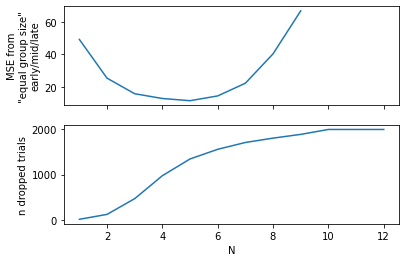

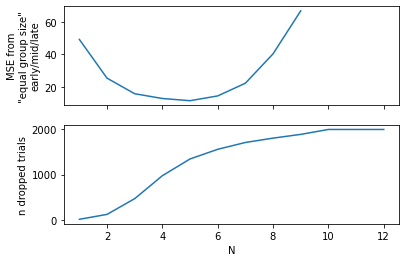

In [72]:
# Calculate optimal N for early/late/classification
# checking the tradeoff n dropped epochs vs. balanced groups early/mid/late
# NOTE: Need to calculate "sample" column +1 because it is 0-indexed
arr = (
    df.groupby(["subject", "trial", "task"])["sample"]
    .max()
    .drop(["AF", "DESC", "YF", "YV"], level=2)
    + 1
).values

# for each potential N (1...12) number of dropped epochs, and mean squared
# error of an equal group size
mses = list()
drops = list()
ns = range(1, 13)
for n in ns:

    ndrop = 0

    nmid = list()
    for val in arr:

        # Check if this trial would be discarded
        if 2 * n > val:
            ndrop += 1
            continue

        # how many trials would be "mid"?
        nmid.append(val - 2 * n)

    # Calc mean squared error
    if np.size(nmid) == 0:
        mses.append(np.nan)
    else:
        mses.append(np.mean((np.array(nmid) - n) ** 2))
    drops.append(ndrop)

# Plot results
fig, axs = plt.subplots(2, 1, sharex=True)
axs.flat[0].plot(ns, mses)
axs.flat[0].set_ylabel('MSE from\n"equal group size"\nearly/mid/late')
axs.flat[1].plot(ns, drops)
axs.flat[1].set_ylabel("n dropped trials")
axs.flat[1].set_xlabel("N")

# Back to epoching

In [110]:
# epoching settings. sample event means onset of mask
# and 0.8s after mask onset: number reward revealed for 0.5s
# trial done at 1.3s
TMIN = -0.5  # see: https://chat.mpib-berlin.mpg.de/arc/pl/1kp1i3qfebfuuxfyaph8fbrngo
TMAX = 1.6
BASELINE = None
DOWNSAMPLE_FREQ = 250.0
OVERWRITE = True

# Number of first/last samples to define as early/late
FIRST_LAST_N = 2

# Event codes of interest
trigger_dict = provide_trigger_dict()

SAMPLE_L_CODE = ord(trigger_dict["trig_mask_out_l"])
SAMPLE_R_CODE = ord(trigger_dict["trig_mask_out_r"])

event_codes_oi = [SAMPLE_L_CODE, SAMPLE_R_CODE]

In [111]:
def run_parallel(subj):
    """Helper func to run the following snippet in parallel.

    Notes
    -----
    Will take the following variables from global space:
    name_templates, OVERWRITE, TASK_NAME_MAP, df, event_codes_oi, TMIN,
    TMAX, BASELINE, DOWNSAMPLE_FREQ

    """
    # Loop over subjects
    # for subj in tqdm(subjects):

    # Handle overwriting
    fname_epochs = name_templates["epochs"].format(subj)
    if op.exists(fname_epochs):
        if not OVERWRITE:
            # continue
            return

    # Get behavioral data
    # Going through tasks, ignoring description for now
    # Append all tasks for this subj into a single data frame
    dfs = list()
    for task in ["ActiveFixed", "ActiveVariable", "YokedFixed", "YokedVariable"]:

        if task_not_present_for_subject(subj, task):
            continue

        task_short = TASK_NAME_MAP[task]
        dfs.append(get_df_for(df, subj, task_short))

    df_ = pd.concat(dfs)

    # Read EEG Events for this subj
    fname_events = name_templates["events"].format(subj)
    events = mne.read_events(fname_events)
    events = drop_error_events(events)

    # Get events of interest
    codes = get_codes_across_tasks(event_codes_oi)
    event_mask = np.isin(events[:, -1], codes)
    events_oi = events[event_mask, :]

    # Enrich the events of interest with additional information
    events, event_id = convert_events(df_, events_oi)

    # load raw data
    fname_cleanraw = name_templates["cleanraw"].format(subj)
    raw = mne.io.read_raw_fif(fname_cleanraw, preload=True, verbose=0)

    # Try to "decimate" the data instead of resampling (i.e., taking every
    # nth sample). Data is already filtered at this point, so no
    # aliasing artifacts occur
    assert raw.info["lowpass"] <= (DOWNSAMPLE_FREQ / 3)
    sfreq = raw.info["sfreq"]
    assert sfreq == 1000
    assert sfreq % DOWNSAMPLE_FREQ == 0
    decim = int(sfreq / DOWNSAMPLE_FREQ)

    # Make epochs and drop those overlapping with "BAD" annotated segments
    # Dropped epochs can be seen in epochs.drop_log
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=event_id,
        tmin=TMIN,
        tmax=TMAX,
        baseline=BASELINE,
        decim=decim,
        reject_by_annotation=True,
        preload=True,
    )

    # Find additional bad epochs and drop them
    bad_epos = find_bad_epochs(epochs)
    epochs.drop(bad_epos, reason="FASTER_AUTOMATIC")

    # Downsample epochs
    # replaced the "epochs.resample(...)"" call with decimation on 2020-07-11
    # see `decim` parameter in mne.Epochs

    # Save epochs
    epochs.save(fname_epochs, overwrite=OVERWRITE)

In [112]:
# multiprocessing using tqdm progress bar
# see: https://stackoverflow.com/a/41921948/5201771
NJOBS = max(1, multiprocessing.cpu_count() - 8)
subjects = range(1, 41)
with multiprocessing.Pool(NJOBS) as pool:
    with tqdm(total=len(subjects)) as pbar:
        for i, _ in enumerate(pool.imap_unordered(run_parallel, subjects)):
            pbar.update()

deleted 127 events.
deleted 339 events.
1086 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1086 events and 2001 original time points ...
77 bad epochs dropped
Dropped 17 epochs
Overwriting existing file.
2400 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2400 events and 2001 original time points ...
71 bad epochs dropped
deleted 227 events.
Dropped 63 epochs
Overwriting existing file.
deleted 52 events.
2400 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2400 events and 2001 original time points ...
169 bad epochs dropped
Dropped 46 epochs
1099 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1099 events and 2001 original time points ...
30 bad epochs dropped
Dropped 26 epochs
Overwriting existing f

Overwriting existing file.
deleted 275 events.
Overwriting existing file.
deleted 884 events.
2400 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2400 events and 2001 original time points ...
31 bad epochs dropped
Dropped 38 epochs
1960 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1960 events and 2001 original time points ...
28 bad epochs dropped
Overwriting existing file.
Dropped 67 epochs
deleted 222 events.
Overwriting existing file.
deleted 257 events.
2400 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2400 events and 2001 original time points ...
171 bad epochs dropped
Dropped 115 epochs
2115 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2115 events and 2001 original time points ...
16 bad

# Calculate percentage dropped epochs per participant

In [5]:
def get_perc_rejected_for_subject(fname):
    """Load epochs and return percentage of rejected epochs."""
    epochs = mne.read_epochs(fname, verbose=0)
    kept_epos = np.array([False if len(i) > 0 else True for i in epochs.drop_log])
    perc_rejected = 100 * (1 - (kept_epos.sum() / len(epochs.drop_log)))
    return fname, perc_rejected, kept_epos.sum()

In [ ]:
# Get rejected epochs per participant in parallel
subjects = range(1, 41)
fnames = [name_templates["epochs"].format(subj) for subj in subjects]
used_names = []
percs = []
absolutes = []
for fname in tqdm(fnames):
    result = get_perc_rejected_for_subject(fname)
    fname, perc, absolute = result
    used_names.append(fname)
    percs.append(perc)
    absolutes.append(absolute)

df_rejected = pd.DataFrame(
    {"fname": used_names, "percent_rejected": percs, "sum_kept": absolutes}
)

df_rejected.head()

In [11]:
min_rej = df_rejected["percent_rejected"].min()
max_rej = df_rejected["percent_rejected"].max()
mean_rej = df_rejected["percent_rejected"].mean()

mean_abs_kept = df_rejected["sum_kept"].mean()

print(
    f"Following this approach, between {min_rej:.2f}% and {max_rej:.2f}% "
    f"(mean={mean_rej:.2f}%) of epochs were rejected per participant.\n\n"
)

print(
    f"By this approach, {100-mean_rej:.2f}% of epochs (n={mean_abs_kept:.0f}) "
    f"were retained for analysis per participant on average"
)

Following this approach, between 2.00% and 15.50% (mean=6.15%) of epochs were rejected per participant.


By this approach, 93.85% of epochs (n=1925) were retained for analysis per participant on average
